#### Imports / Modules

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import keras
from keras import layers

#### Loading the dataset

In [78]:
df = pd.read_csv("usa_housing_kaggle.csv")
df.head()

,Price,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,ZipCode,CrimeRate,SchoolRating
0,221958,1,1.90,4827,1979,2,1.45,82240,48.60,5
1,771155,2,2.00,1035,1987,2,1.75,74315,92.03,9
2,231932,1,3.00,2769,1982,1,1.46,79249,52.08,3
3,465838,3,3.30,2708,1907,3,1.62,80587,61.65,1
4,359178,4,3.40,1175,1994,2,0.74,20756,15.66,4


In [79]:
len(df)

300

#### Handle missing values

In [80]:
df.isna().sum()

Price           0
Bedrooms        0
Bathrooms       0
SquareFeet      0
YearBuilt       0
GarageSpaces    0
LotSize         0
ZipCode         0
CrimeRate       0
SchoolRating    0
dtype: int64

In [81]:
int(df.duplicated().sum())

0

#### X/y-Split

In [82]:
X = df.drop(["Price", "ZipCode"], axis=1)

y = df["Price"]

<Axes: >

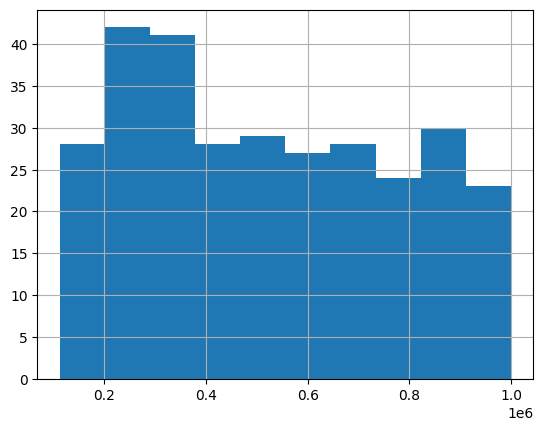

In [83]:
df['Price'].hist()

#### Inspect the variables - Correlation

In [84]:
correlations = df.corr(numeric_only=True)
correlations

,Price,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,ZipCode,CrimeRate,SchoolRating
Price,1.00,0.02,0.04,0.04,0.01,0.01,-0.02,-0.02,0.01,0.02
Bedrooms,0.02,1.00,-0.04,-0.06,-0.03,-0.04,-0.05,0.11,0.01,0.01
Bathrooms,0.04,-0.04,1.00,0.01,-0.07,-0.01,-0.10,0.04,0.01,0.06
SquareFeet,0.04,-0.06,0.01,1.00,-0.00,0.05,0.01,-0.01,-0.04,0.00
YearBuilt,0.01,-0.03,-0.07,-0.00,1.00,0.09,-0.10,-0.03,-0.02,0.00
GarageSpaces,0.01,-0.04,-0.01,0.05,0.09,1.00,0.11,0.01,-0.01,0.03
LotSize,-0.02,-0.05,-0.10,0.01,-0.10,0.11,1.00,0.12,0.03,-0.04
ZipCode,-0.02,0.11,0.04,-0.01,-0.03,0.01,0.12,1.00,-0.01,-0.03
CrimeRate,0.01,0.01,0.01,-0.04,-0.02,-0.01,0.03,-0.01,1.00,-0.02
SchoolRating,0.02,0.01,0.06,0.00,0.00,0.03,-0.04,-0.03,-0.02,1.00


#### Fisher's score

d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


<Axes: >

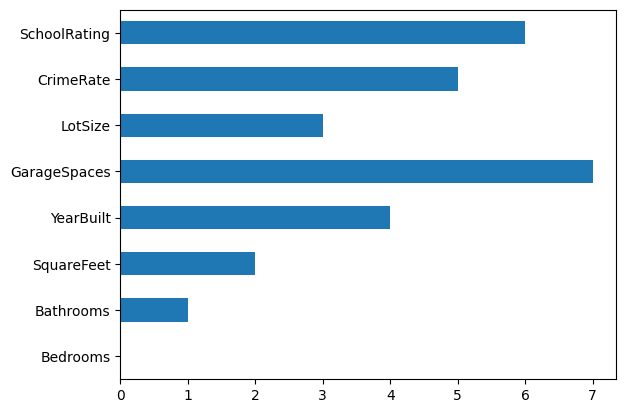

In [85]:
from skfeature.function.similarity_based import fisher_score

ranks = fisher_score.fisher_score(X.values, y.values)
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

In [87]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))
best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
2,SquareFeet,139860.48
6,CrimeRate,5086.90
7,SchoolRating,419.53
4,GarageSpaces,246.44
0,Bedrooms,212.25
3,YearBuilt,197.50
5,LotSize,139.66
1,Bathrooms,109.25


#### VIF-Test

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 

print(vif_data)

        feature   VIF
0      Bedrooms  5.22
1     Bathrooms  8.79
2    SquareFeet  7.59
3     YearBuilt 32.39
4  GarageSpaces  2.90
5       LotSize  4.90
6     CrimeRate  3.94
7  SchoolRating  4.67


#### Train/test/validation -split

In [89]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#### Create the neural network structure

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

variable_amount = len(X.columns)

mc = ModelCheckpoint('best_model_small_dataset.keras', monitor='val_loss', mode='min', save_best_only=True)

callback_list = [mc]

model4 = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.3, l2=0.3)),
        layers.Dropout(0.2),
        layers.Dense(10, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)

model4.compile(optimizer='adam', loss='mse')
model4.summary()

d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443 (1.73 KB)

 Trainable params: 427 (1.67 KB)

 Non-trainable params: 16 (64.00 B)

#### Train the neural network

In [91]:
model4.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 330395025408.0000 - val_loss: 370808520704.0000
Epoch 2/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 330394927104.0000 - val_loss: 370802982912.0000
Epoch 3/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 330394861568.0000 - val_loss: 370799411200.0000
Epoch 4/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 330394697728.0000 - val_loss: 370796134400.0000
Epoch 5/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 330394501120.0000 - val_loss: 370793480192.0000
Epoch 6/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 330394402816.0000 - val_loss: 370790760448.0000
Epoch 7/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 330394206208.0000 - val_loss: 370787876864.0000
Epoch 8/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 330393845760.0000 - val_loss: 370785386496.0000
Epoch 9/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 330393583616.0000 - val_loss: 370783125504.0000
Epoch 10/800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

#### Performance and Error Metrics

<Axes: >

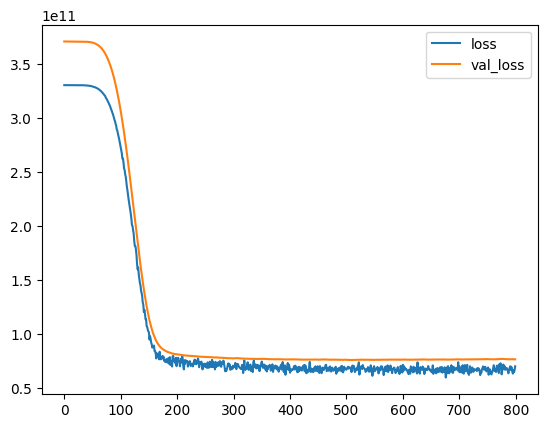

In [92]:
loss_df = pd.DataFrame(model4.history.history)
loss_df.plot()

#### Load the best model version

In [ ]:
from keras.models import load_model
model4 = load_model("best_model_small_dataset.keras")

In [94]:
print("Test data evaluation:")
print(model4.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model4.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
74258284544.0

Train data evaluation:
63351427072.0


In [95]:
test_predictions = model4.predict(X_test)

test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

pred_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


,Test True Y,Model Predictions
0,353618,539517.31
1,187498,524827.19
2,219176,492513.50
3,961882,492093.75
4,691723,465586.56
5,877089,536681.81
6,998613,543182.62
7,818315,511272.97
8,471369,574203.31
9,628178,439917.47


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

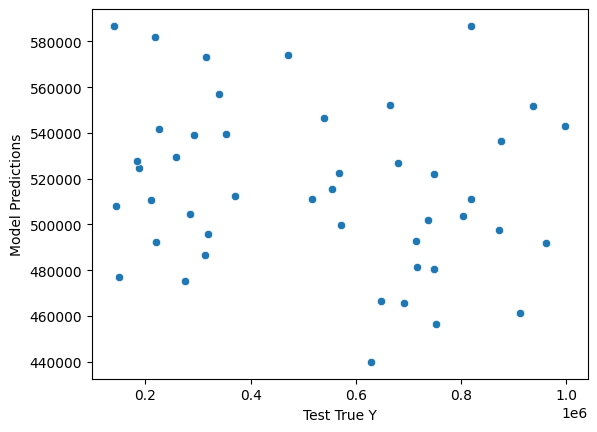

In [96]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [97]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
246604.09 $

MSE
74258292736.0 $^2

RMSE:
272503.75 $

R-squared:
-0.07

Explained variance score:
-0.07


C:\Users\Timothy\AppData\Local\Temp\ipykernel_13356\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


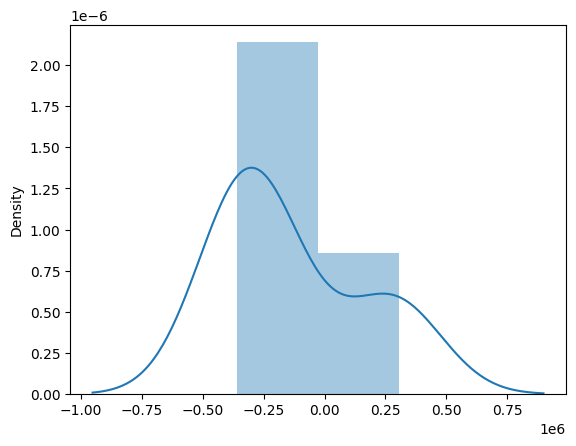

In [98]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [99]:
df.columns

Index(['Price', 'Bedrooms', 'Bathrooms', 'SquareFeet', 'YearBuilt',
       'GarageSpaces', 'LotSize', 'ZipCode', 'CrimeRate', 'SchoolRating'],
      dtype='object')

#### Trying the model in practice with new imaginery house

In [101]:
tester_row = {
    "Bedrooms": 5,
    "Bathrooms": 3.7,
    "SquareFeet": 3530,
    "YearBuilt": 1954,
    "GarageSpaces": 2,
    "LotSize": 0.74,
    "CrimeRate": 2.91,
    "SchoolRating": 6
}

tester_row = pd.DataFrame([tester_row])


In [102]:
result = model4.predict(tester_row)[0]

print()
print(f"Estimated energy bill for this house:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Estimated energy bill for this house:
$ 574116.81
----------------
